In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 45.2 MB/s 


In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import pickle
from pprint import pprint
import re
#from wordcloud import WordCloud

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [4]:
total_data= pd.read_csv('/content/drive/Shareddrives/흐사드/0702_0706_파일정리/벤포벨/벤포벨_2019_2022.csv',encoding='utf-8')
total_data

,Unnamed: 0,날짜,제목,연도
0,113,20190131,"[설 특집] 종근당 고함량 활성비타민, 하루 한 알로 '명절증후군' 해소",2019
1,114,20190130,황금돼지해 설 건강선물 1위 ‘활력 비타민’,2019
2,115,20190126,"명절 건강 선물, 미래형 보약 대신 ‘현재형 원기회복’",2019
3,116,20190122,"종근당, 국민건강-국부창출 두 마리 토끼잡기",2019
4,117,20190116,"종근당, 고함량 기능성 활성비타민 '벤포벨' 각광",2019
...,...,...,...,...
2971,1165,20220304,벤포벨 질문이요,2022
2972,1166,20220304,"비맥스,벤포벨 중 고민…",2022
2973,1167,20220303,"비타민(벤포벨), 오메가3, 유산균 세 개 동시에 먹어도 상관없을까요?",2022
2974,1168,20220302,벤포벨 복용 후기,2022


In [5]:
total_data=total_data[['날짜','제목']]
total_data=total_data.drop_duplicates()
total_data

,날짜,제목
0,20190131,"[설 특집] 종근당 고함량 활성비타민, 하루 한 알로 '명절증후군' 해소"
1,20190130,황금돼지해 설 건강선물 1위 ‘활력 비타민’
2,20190126,"명절 건강 선물, 미래형 보약 대신 ‘현재형 원기회복’"
3,20190122,"종근당, 국민건강-국부창출 두 마리 토끼잡기"
4,20190116,"종근당, 고함량 기능성 활성비타민 '벤포벨' 각광"
...,...,...
2971,20220304,벤포벨 질문이요
2972,20220304,"비맥스,벤포벨 중 고민…"
2973,20220303,"비타민(벤포벨), 오메가3, 유산균 세 개 동시에 먹어도 상관없을까요?"
2974,20220302,벤포벨 복용 후기


In [6]:
#데이터 프레임의 'text' 열의 값들을 str 형식으로 바꾸기
total_data.제목 = total_data.제목.astype(str)


#데이터 프레임의 'text' 열의 값 중 keyword1이나 keyword 2가 포함된 행은 삭제
#clean_Data = total_data[~total_data['제목'].str.contains('keyword1|keyword2')]


#text와 timestamp 열을 기준으로 중복된 데이터를 삭제, inplace : 데이터 프레임을 변경할지 선택(원본을 대체)
total_data.drop_duplicates(subset=['제목','날짜'], inplace=True)

#빈 문자열 NAN 값으로 바꾸기
total_data = total_data.replace({'': np.nan})
total_data = total_data.replace(r'^\s*$', None, regex=True)

#NAN 이 있는 행은 삭제
total_data.dropna(how='any', inplace=True)

#인덱스 차곡차곡
total_data = total_data.reset_index (drop = True)

#데이터 프레임에 null 값이 있는지 확인
print(total_data.isnull().values.any()) 

False


In [7]:
#텍스트 데이터를 리스트로 변환
Data_li=total_data.제목.values.tolist()
Data_li

["[설 특집] 종근당 고함량 활성비타민, 하루 한 알로 '명절증후군' 해소",
 '황금돼지해 설 건강선물 1위 ‘활력 비타민’',
 '명절 건강 선물, 미래형 보약 대신 ‘현재형 원기회복’',
 '종근당, 국민건강-국부창출 두 마리 토끼잡기',
 "종근당, 고함량 기능성 활성비타민 '벤포벨' 각광",
 '[클릭 e상품]  고함량 활성비타민 함유',
 '[국가대표 건강 도우미] 활성형 비타민B1, 약효 빠르고 오래 가',
 '하루 한 알 ‘벤포벨’…만성피로 끝',
 "현대인 건강관리에 필요한 성분 처방…종근당 고함량 기능성 활성비타민 '벤포벨'",
 "['봄 불청객' 이겨내기]종근당 '벤포벨'",
 '종근당, 활성비타민 \'벤포벨\' 주목…"피로회복·건강관리 효과"',
 '명절 증후군 극복 위한 건강기능식품',
 '명절 증후군 극복 위한 건강기능식품은?',
 '[헬스 파일] 서울대병원, ‘이름 없는 병원’ 시스템 시행',
 '종근당, ‘벤포벨’ 한 알로 피로회복·건강관리',
 "[베스트브랜드]종근당 고함량 기능성 활성비타민 '벤포벨', 하루 한 알로 현대인의 피로회복...",
 "[나른한 봄 건강 지키기]종근당 '벤포벨'",
 "하루 한알로 필요 비타민 OK…종근당 고함량 활성비타민제 '벤포벨'",
 '고함량 활성비타민 시장 급성장…종근당 ‘벤포벨’ 피로회복 효과 관심',
 "하루 한 알로 만성피로 관리 ‘OK’ ['국민 상품' 매력 탐구]",
 '제약업계 가정의달 선물②) 봄건강은 활력-혈액순환',
 "종근당, 활성비타민 '벤포벨' 광고 모델로 배우 배성우 선정",
 '배우 배성우, 종근당 ‘벤포벨’ TV광고 모델',
 "'약사 유튜버'가 불지핀 아로나민 효능 논란",
 '종근당, 활성비타민 ‘벤포벨’ 광고모델 배우 배성우 발탁',
 "종근당, 고함량 활성비타민 '벤포벨' TV광고 개시",
 '종근당, 배우 배성우 모델로 ‘벤포벨’ TV 광고 시작',
 '종근당, 배우 배성우 내세운 고함량활성비타민 벤포벨 TV 광고 온에어',
 "종근당, 고함량 활성비타민 

In [8]:
company=['임팩타민','비맥스메타','씨플러스','우루사','코엔자임']
out=list()

for i in Data_li:
  if company[0] in i or company[1] in i or company[2] in i or company[3] in i or company[4] in i:
    pass
  else:
    out.append(i)


In [9]:
out

["[설 특집] 종근당 고함량 활성비타민, 하루 한 알로 '명절증후군' 해소",
 '황금돼지해 설 건강선물 1위 ‘활력 비타민’',
 '명절 건강 선물, 미래형 보약 대신 ‘현재형 원기회복’',
 '종근당, 국민건강-국부창출 두 마리 토끼잡기',
 "종근당, 고함량 기능성 활성비타민 '벤포벨' 각광",
 '[클릭 e상품]  고함량 활성비타민 함유',
 '[국가대표 건강 도우미] 활성형 비타민B1, 약효 빠르고 오래 가',
 '하루 한 알 ‘벤포벨’…만성피로 끝',
 "현대인 건강관리에 필요한 성분 처방…종근당 고함량 기능성 활성비타민 '벤포벨'",
 "['봄 불청객' 이겨내기]종근당 '벤포벨'",
 '종근당, 활성비타민 \'벤포벨\' 주목…"피로회복·건강관리 효과"',
 '명절 증후군 극복 위한 건강기능식품',
 '명절 증후군 극복 위한 건강기능식품은?',
 '[헬스 파일] 서울대병원, ‘이름 없는 병원’ 시스템 시행',
 '종근당, ‘벤포벨’ 한 알로 피로회복·건강관리',
 "[베스트브랜드]종근당 고함량 기능성 활성비타민 '벤포벨', 하루 한 알로 현대인의 피로회복...",
 "[나른한 봄 건강 지키기]종근당 '벤포벨'",
 "하루 한알로 필요 비타민 OK…종근당 고함량 활성비타민제 '벤포벨'",
 '고함량 활성비타민 시장 급성장…종근당 ‘벤포벨’ 피로회복 효과 관심',
 "하루 한 알로 만성피로 관리 ‘OK’ ['국민 상품' 매력 탐구]",
 '제약업계 가정의달 선물②) 봄건강은 활력-혈액순환',
 "종근당, 활성비타민 '벤포벨' 광고 모델로 배우 배성우 선정",
 '배우 배성우, 종근당 ‘벤포벨’ TV광고 모델',
 "'약사 유튜버'가 불지핀 아로나민 효능 논란",
 '종근당, 활성비타민 ‘벤포벨’ 광고모델 배우 배성우 발탁',
 "종근당, 고함량 활성비타민 '벤포벨' TV광고 개시",
 '종근당, 배우 배성우 모델로 ‘벤포벨’ TV 광고 시작',
 '종근당, 배우 배성우 내세운 고함량활성비타민 벤포벨 TV 광고 온에어',
 "종근당, 고함량 활성비타민 

In [10]:
Data_list=out
Data_list

["[설 특집] 종근당 고함량 활성비타민, 하루 한 알로 '명절증후군' 해소",
 '황금돼지해 설 건강선물 1위 ‘활력 비타민’',
 '명절 건강 선물, 미래형 보약 대신 ‘현재형 원기회복’',
 '종근당, 국민건강-국부창출 두 마리 토끼잡기',
 "종근당, 고함량 기능성 활성비타민 '벤포벨' 각광",
 '[클릭 e상품]  고함량 활성비타민 함유',
 '[국가대표 건강 도우미] 활성형 비타민B1, 약효 빠르고 오래 가',
 '하루 한 알 ‘벤포벨’…만성피로 끝',
 "현대인 건강관리에 필요한 성분 처방…종근당 고함량 기능성 활성비타민 '벤포벨'",
 "['봄 불청객' 이겨내기]종근당 '벤포벨'",
 '종근당, 활성비타민 \'벤포벨\' 주목…"피로회복·건강관리 효과"',
 '명절 증후군 극복 위한 건강기능식품',
 '명절 증후군 극복 위한 건강기능식품은?',
 '[헬스 파일] 서울대병원, ‘이름 없는 병원’ 시스템 시행',
 '종근당, ‘벤포벨’ 한 알로 피로회복·건강관리',
 "[베스트브랜드]종근당 고함량 기능성 활성비타민 '벤포벨', 하루 한 알로 현대인의 피로회복...",
 "[나른한 봄 건강 지키기]종근당 '벤포벨'",
 "하루 한알로 필요 비타민 OK…종근당 고함량 활성비타민제 '벤포벨'",
 '고함량 활성비타민 시장 급성장…종근당 ‘벤포벨’ 피로회복 효과 관심',
 "하루 한 알로 만성피로 관리 ‘OK’ ['국민 상품' 매력 탐구]",
 '제약업계 가정의달 선물②) 봄건강은 활력-혈액순환',
 "종근당, 활성비타민 '벤포벨' 광고 모델로 배우 배성우 선정",
 '배우 배성우, 종근당 ‘벤포벨’ TV광고 모델',
 "'약사 유튜버'가 불지핀 아로나민 효능 논란",
 '종근당, 활성비타민 ‘벤포벨’ 광고모델 배우 배성우 발탁',
 "종근당, 고함량 활성비타민 '벤포벨' TV광고 개시",
 '종근당, 배우 배성우 모델로 ‘벤포벨’ TV 광고 시작',
 '종근당, 배우 배성우 내세운 고함량활성비타민 벤포벨 TV 광고 온에어',
 "종근당, 고함량 활성비타민 

In [11]:
from konlpy.tag import Okt
okt = Okt()

In [12]:
okt.nouns(Data_list[0])

['설', '특집', '종근당', '함량', '활', '비타민', '하루', '알', '명절', '증후군', '해소']

In [13]:

#리스트를 요소별로(트윗 하나) 가져와서 명사만 추출한 후 리스트로 저장
data_word=[]
#스탑워드
stopword=['로나', '민', '골드','아로','좀','양제','비타민','영',"제","거","요","뭐","알","살","수","새","왜","나","집","것","주","게","정","때","및","포벨","개","일","난",'온',"프리지아","동생","배성재","전","저",'분',"말","오윤수","줄","표","넹","비","중","만","일","함","뭘","구","글","정","더","이","를","내","후","로","니","이"]
for i in range(len(Data_list)):
  k=[]
  try:
      a=okt.nouns(Data_list[i])
      for j in a:
        if j not in stopword:
          k.append(j)
      data_word.append(k)
  except Exception as e:
        continue


#트윗에서 형태소 추출해서 만든 리스트
data_word

[['설', '특집', '종근당', '함량', '활', '하루', '명절', '증후군', '해소'],
 ['황금돼지', '설', '건강', '선물', '위', '활'],
 ['명절', '건강', '선물', '미래', '보약', '대신', '현재', '원기', '회복'],
 ['종근당', '국민', '건강', '국부', '창', '두', '마리', '토끼', '잡기'],
 ['종근당', '함량', '기능', '활', '각광'],
 ['클릭', '상품', '함량', '활', '함유'],
 ['국가대표', '건강', '도우미', '활', '성형', '약효'],
 ['하루', '만성', '피로', '끝'],
 ['현대인', '건강', '관리', '성분', '처방', '종근당', '함량', '기능', '활'],
 ['봄', '불청객', '종근당'],
 ['종근당', '활', '주목', '피로', '회복', '건강', '관리', '효과'],
 ['명절', '증후군', '극복', '위', '건강', '기능', '식품'],
 ['명절', '증후군', '극복', '위', '건강', '기능', '식품'],
 ['헬스', '파일', '서울대', '병원', '이름', '병원', '시스템', '시행'],
 ['종근당', '피로', '회복', '건강', '관리'],
 ['베스트', '브랜드', '종근당', '함량', '기능', '활', '하루', '현대인', '피로', '회복'],
 ['봄', '건강', '종근당'],
 ['하루', '필요', '종근당', '함량', '활'],
 ['함량', '활', '시장', '급성', '종근당', '피로', '회복', '효과', '관심'],
 ['하루', '만성', '피로', '관리', '국민', '상품', '매력', '탐구'],
 ['제약업', '가정', '달', '선물', '봄', '건강', '활', '혈액', '순환'],
 ['종근당', '활', '광고', '모델', '배우', '배성우', '선정'],
 ['배우', '배성우', '종근당', '

In [14]:
from gensim import corpora

# 각 단어를 (단어id, 나온횟수) 로 바꾸는 작업
dictionary = corpora.Dictionary(data_word)
corpus = [dictionary.doc2bow(text) for text in data_word]

In [15]:
import gensim

In [16]:
import matplotlib.pyplot as plt
perplexity_values=[]
for i in range(2,15):
  ldamodel=gensim.models.ldamodel.LdaModel(corpus,num_topics=i,id2word=dictionary)
  perplexity_values.append(ldamodel.log_perplexity(corpus))

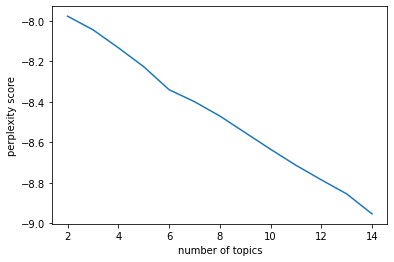

In [17]:
x=range(2,15)
plt.plot(x,perplexity_values)
plt.xlabel("number of topics")
plt.ylabel("perplexity score")
plt.show()

In [18]:
from gensim.models import CoherenceModel
coherance_values=[]
for i in range(2,15):
  ldamodel=gensim.models.ldamodel.LdaModel(corpus,num_topics=i,id2word=dictionary)
  coherance_model_lda=CoherenceModel(model=ldamodel,texts=data_word,dictionary=dictionary,topn=10)
  coherance_lda=coherance_model_lda.get_coherence()
  coherance_values.append(coherance_lda)

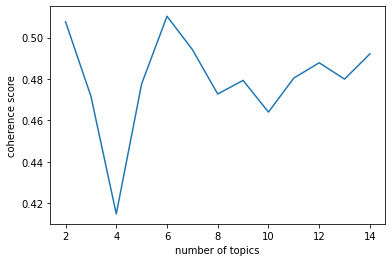

In [19]:
x=range(2,15)
plt.plot(x,coherance_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

In [20]:
# corpus[i] : i번째 뉴스에서 나온단어들을 가지고 (단어id, 나온횟수)들을 저장한 list
print(corpus[1]) 


# dictionary[j] : id값을 j를 가진 단어가 무엇인지 확인
print(dictionary[66])

[(1, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]
제약업


In [21]:
import gensim

NUM_TOPICS = 6

# passes : 알고리즘 동작횟수, num_words : 각 토픽별 출력할 단어
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.012*"종근당" + 0.008*"건강" + 0.007*"안" + 0.006*"약국"')
(1, '0.012*"선물" + 0.008*"생각" + 0.007*"음식" + 0.007*"명절"')
(2, '0.028*"약국" + 0.015*"복용" + 0.013*"제품" + 0.012*"성분"')
(3, '0.006*"종근당" + 0.006*"효과" + 0.006*"곳" + 0.005*"매출"')
(4, '0.007*"건강" + 0.007*"제품" + 0.007*"약국" + 0.006*"피부"')
(5, '0.026*"피로" + 0.014*"종근당" + 0.013*"함량" + 0.012*"활"')


In [22]:
# 각 토픽별 10개의 단어를 단어를 출력 (위 코드에서 num_words=10을 한것)
for i in range(NUM_TOPICS):
    print(ldamodel.print_topics()[i])

(0, '0.012*"종근당" + 0.008*"건강" + 0.007*"안" + 0.006*"약국" + 0.005*"가격" + 0.005*"생각" + 0.005*"음식" + 0.004*"의약품" + 0.004*"추석" + 0.004*"결과"')
(1, '0.012*"선물" + 0.008*"생각" + 0.007*"음식" + 0.007*"명절" + 0.007*"추석" + 0.006*"테스트" + 0.006*"결과" + 0.005*"보건소" + 0.005*"증후군" + 0.005*"약사"')
(2, '0.028*"약국" + 0.015*"복용" + 0.013*"제품" + 0.012*"성분" + 0.010*"함량" + 0.007*"함유" + 0.007*"등" + 0.007*"약" + 0.007*"환자" + 0.006*"종합"')
(3, '0.006*"종근당" + 0.006*"효과" + 0.006*"곳" + 0.005*"매출" + 0.005*"제품" + 0.005*"생각" + 0.005*"두드러기" + 0.004*"아시" + 0.004*"유산균" + 0.004*"구입"')
(4, '0.007*"건강" + 0.007*"제품" + 0.007*"약국" + 0.006*"피부" + 0.006*"구매" + 0.005*"몸" + 0.005*"유산균" + 0.005*"하루" + 0.005*"콜라겐" + 0.005*"하나"')
(5, '0.026*"피로" + 0.014*"종근당" + 0.013*"함량" + 0.012*"활" + 0.010*"약국" + 0.009*"하루" + 0.008*"회복" + 0.008*"효과" + 0.007*"건강" + 0.007*"추천"')


In [23]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=4817ed09612a1a22d00256d0ff4ce6cc8264fe29f957c18363e6560085994de7
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [24]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [25]:
for i, topic_list in enumerate(ldamodel[corpus]):
    if i==5:
        break
    print(i,'번째 문서의 topic 비율은',topic_list)

0 번째 문서의 topic 비율은 [(0, 0.016725354), (1, 0.5612456), (2, 0.01681469), (3, 0.016724449), (4, 0.016704906), (5, 0.37178496)]
1 번째 문서의 topic 비율은 [(0, 0.02402374), (1, 0.6527804), (2, 0.024115467), (3, 0.023948284), (4, 0.02395609), (5, 0.251176)]
2 번째 문서의 topic 비율은 [(0, 0.016745407), (1, 0.72852015), (2, 0.016719496), (3, 0.016717006), (4, 0.016800743), (5, 0.20449717)]
3 번째 문서의 topic 비율은 [(0, 0.9163116), (1, 0.016723037), (2, 0.016691193), (3, 0.016825644), (4, 0.01670644), (5, 0.01674207)]
4 번째 문서의 topic 비율은 [(0, 0.027999492), (1, 0.02782208), (2, 0.027892543), (3, 0.027811429), (4, 0.027824817), (5, 0.86064965)]


In [26]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [27]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']
topictable[:10]

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,1.0,0.5613,"[(0, 0.016725363), (1, 0.5613124), (2, 0.01681..."
1,1,1.0,0.6554,"[(0, 0.02402428), (1, 0.6554466), (2, 0.024109..."
2,2,1.0,0.7285,"[(0, 0.016745403), (1, 0.7284882), (2, 0.01671..."
3,3,0.0,0.9163,"[(0, 0.9163109), (1, 0.016723039), (2, 0.01669..."
4,4,5.0,0.8606,"[(0, 0.027999893), (1, 0.02782208), (2, 0.0278..."
5,5,2.0,0.8606,"[(0, 0.027804071), (1, 0.027838858), (2, 0.860..."
6,6,5.0,0.3557,"[(0, 0.02389231), (1, 0.1814758), (2, 0.191893..."
7,7,5.0,0.8328,"[(0, 0.03340762), (1, 0.033385284), (2, 0.0333..."
8,8,5.0,0.9162,"[(0, 0.016778665), (1, 0.016753225), (2, 0.016..."
9,9,5.0,0.7912,"[(0, 0.041829363), (1, 0.041774295), (2, 0.041..."
